In this notebgook wea re going to try different Ml methods to predict employee satisfation given a number of indicators like employee identification numbers, self-reported satisfaction levels, performance evaluations, project involvement, work hours, tenure with the company, work accidents, promotions received in the last 5 years, departmental affiliations, and salary levels

We are also going to get insigt in the importance of each indicator using correlation/chi and decision trees.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Lets take a look at the data first

In [61]:
df = pd.read_csv("/kaggle/input/employees-satisfaction-analysis/Employee Attrition.csv")
df.info()
df.pop("Emp ID")

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,dept,salary
0,0.38,0.53,2.0,157.0,3.0,0.0,0.0,sales,low
1,0.80,0.86,5.0,262.0,6.0,0.0,0.0,sales,medium
2,0.11,0.88,7.0,272.0,4.0,0.0,0.0,sales,medium
3,0.72,0.87,5.0,223.0,5.0,0.0,0.0,sales,low
4,0.37,0.52,2.0,159.0,3.0,0.0,0.0,sales,low
...,...,...,...,...,...,...,...,...,...
15782,0.40,0.57,2.0,151.0,3.0,0.0,0.0,support,low
15783,0.37,0.48,2.0,160.0,3.0,0.0,0.0,support,low
15784,0.37,0.53,2.0,143.0,3.0,0.0,0.0,support,low
15785,0.11,0.96,6.0,280.0,4.0,0.0,0.0,support,low


Most features are continuous, lets encode the categorical features into entire numbers. 

In [62]:
from sklearn.preprocessing import LabelEncoder

In [63]:
dict_label = dict()
for col in df.columns:
    if df[col].dtype == np.dtype("object"):
        dict_label[col] = LabelEncoder()
        df[col] = dict_label[col].fit_transform(df[col])
    else:
        # lets impute the numerica values using the mean
        df[col] = df[col].fillna(df[col].mean())



In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15787 entries, 0 to 15786
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     15787 non-null  float64
 1   last_evaluation        15787 non-null  float64
 2   number_project         15787 non-null  float64
 3   average_montly_hours   15787 non-null  float64
 4   time_spend_company     15787 non-null  float64
 5   Work_accident          15787 non-null  float64
 6   promotion_last_5years  15787 non-null  float64
 7   dept                   15787 non-null  int64  
 8   salary                 15787 non-null  int64  
dtypes: float64(7), int64(2)
memory usage: 1.1 MB


We are going to get the feature importance using a decision tree

In [65]:
from sklearn.tree import DecisionTreeRegressor

In [66]:
y = df.pop("satisfaction_level")
X = df

In [67]:
dtr = DecisionTreeRegressor()
dtr.fit(X,y)
importance = {str(col):feat_imp for col,feat_imp in zip(df.columns,dtr.feature_importances_)}
print(importance)

{'last_evaluation': 0.18720778558619422, 'number_project': 0.3537523674966449, 'average_montly_hours': 0.2527016356257055, 'time_spend_company': 0.06323135961556985, 'Work_accident': 0.019246980358169876, 'promotion_last_5years': 0.005512464108666737, 'dept': 0.0784377667942362, 'salary': 0.0399096404148127}


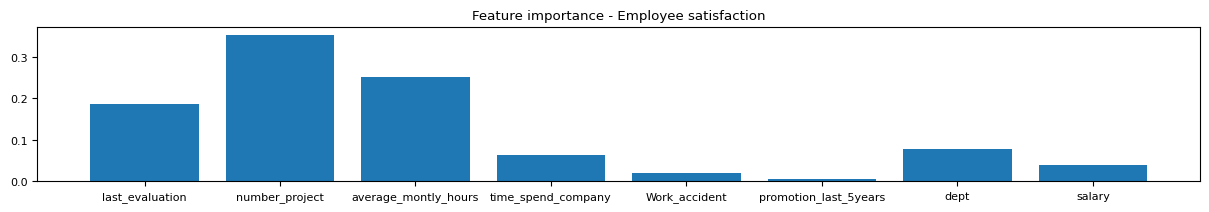

In [140]:
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 8
plt.rcParams['figure.figsize'] = [15, 2]
plt.bar(list(importance.keys()),list(importance.values()))
plt.title("Feature importance - Employee satisfaction")
plt.show()

Apparently, Evaluation results, number of projects and work hours are more important than promotions and salary.
We are going to use LE,NP and AMH to predict employee satisfaction and observe its MSE and MAPE. The model we are goign to train is a GBT using Xgboost, as tree methods are particularly good at working with tabular data.

First lets get the best features acording to our analysis

In [215]:
names = np.array(list(importance.keys()))
feature_importance = list(importance.values())
sorted_fi = np.argsort(feature_importance)[::-1]
selected_features = names[sorted_fi]
df_sf =df[selected_features]
X = df_sf

We are going to split our data into a test and train splits. 
We might add k fold later.

In [216]:
from sklearn.model_selection import train_test_split

In [217]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = .2)

In [218]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [225]:
   
early_stop = xgb.callback.EarlyStopping(
rounds=8, metric_name='r2_score', save_best=True,maximize = True
)

print("traing...")

rf = xgb.XGBRegressor(n_estimators = 10000,callbacks=[early_stop], learning_rate = .01, eval_metric = r2_score)

rf.fit(X_train,y_train,eval_set=[(X_test, y_test)], verbose = False)



traing...


XGBRegressor(base_score=None, booster=None,
             callbacks=[<xgboost.callback.EarlyStopping object at 0x7a969ecf4a60>],
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function r2_score at 0x7a96c8179240>,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None, ...)

Lets evaluate performace...

In [226]:
test_pred = rf.predict(X_test)
print(mean_squared_error(y_test,test_pred))
print(mean_absolute_percentage_error(y_test,test_pred))
print(r2_score(y_test,test_pred))
print(mean_absolute_error(y_test,test_pred))

0.03175025266957144
0.28915060898375533
0.45854332679229537
0.1285435504296071


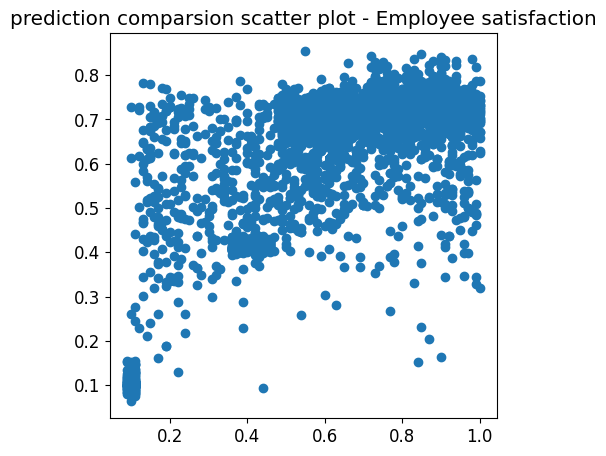

In [227]:
plt.rcParams["font.size"] = 12
plt.rcParams['figure.figsize'] = [5, 5]
plt.scatter(y_test,test_pred)
plt.title("prediction comparsion scatter plot - Employee satisfaction")
plt.show()

In [228]:
train_pred = rf.predict(X_train)
print(mean_squared_error(y_train,train_pred))
print(mean_absolute_percentage_error(y_train,train_pred))
print(r2_score(y_train,train_pred))
print(mean_absolute_error(y_train,train_pred))

0.022644837196360606
0.2523695613459837
0.6145525044951374
0.10999685769493255


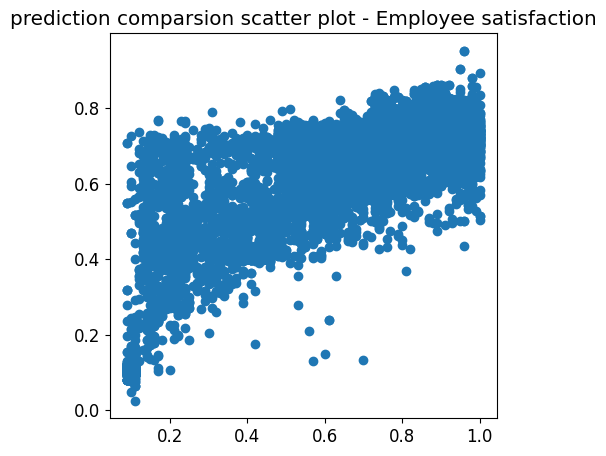

In [229]:
plt.rcParams["font.size"] = 12
plt.rcParams['figure.figsize'] = [5, 5]
plt.scatter(y_train,train_pred)
plt.title("prediction comparsion scatter plot - Employee satisfaction")

plt.show()